# Review


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train_arr, y_train_arr), (x_test_arr, y_test_arr) = mnist.load_data()
# convert the input to tensors


2024-11-25 08:57:43.896060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732553863.908332   13897 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732553863.912065   13897 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 08:57:43.924286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


I'm getting all these errors above, but I've tested that my gpu is still working perfectly, so I was told to ignore these warnings by chatGPT.

In [28]:
x_train, x_test, y_train, y_test = tf.convert_to_tensor(x_train_arr), tf.convert_to_tensor(x_test_arr), tf.convert_to_tensor(y_train_arr), tf.convert_to_tensor(y_test_arr)


In [ ]:
import tensorflow as tf

# I'm trying to make a first nearest neighbor model using cosine similarity

def first_nn_model(input):
    # Flatten the input
    flattened_input = tf.reshape(tf.cast(input, tf.float32), [1, -1])
    # Flatten the images to 1D vectors
    x_train_vectors = tf.reshape(tf.cast(x_train, tf.float32), [x_train.shape[0], -1])

    # Normalize the vectors to compute cosine similarity
    x_train_0_norm = tf.linalg.l2_normalize(flattened_input)
    x_train_flat_norm = tf.linalg.l2_normalize(x_train_vectors, axis=1)

    # Compute cosine similarity
    cosine_similarities = tf.linalg.matvec(x_train_flat_norm, x_train_0_norm)

    predicted_label = tf.argmax(cosine_similarities)
    return predicted_label

first_nn_model(x_train[0:1])

<tf.Tensor: shape=(60000,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

Let's start with a dummy model that just spits out random probabilities for each class. 

In [84]:
import tensorflow as tf

# Define the uniform model
num_classes = 10  # Adjust to your number of classes
uniform_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28)),  # Placeholder input, adjust as needed
    tf.keras.layers.Lambda(lambda x: tf.fill((tf.shape(x)[0], num_classes), 1.0 / num_classes))
])

In [ ]:
# perfect model

perfect_model = tf.keras.Sequential([
    
])

As expected this outputs a prediction vector where every class has an equal probability.

In [85]:

pred_train = uniform_model(x_train)

pred_train.numpy()

array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]], dtype=float32)

As we expect, with the uniform model, every class gets a probability of .1.



In [81]:
one_hot = tf.one_hot(y_train, 10)
one_hot.numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>>

Idea, we can see how likely we say the correct class of being by taking a dot product of these two.

We don't know how to do dot products yet, but let's guess by starting with an *.

In [82]:
one_hot * pred_train

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.1, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.1, 0. ]], dtype=float32)>

This is close, is actually just multiplies these two tensors elementwise. 

In [76]:
tf.reduce_sum(one_hot * pred_train, axis=1).numpy()

array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1], dtype=float32)

There it is, we can see, as expected, that the model always outputs a prediction of .1 for each correct each class.

## Cross Entropy Error

Say the model is looking at a '4', a perfect model would assign a 100% probability to 4. The worst model would assign a 0% probability to 4.

To come up with a loss function, we will need a function that looks like this:

/tmp/ipykernel_12124/1813527820.py:9: RuntimeWarning: divide by zero encountered in log
  y = -np.log(x)


Text(0.5, 1.0, 'Loss Function')

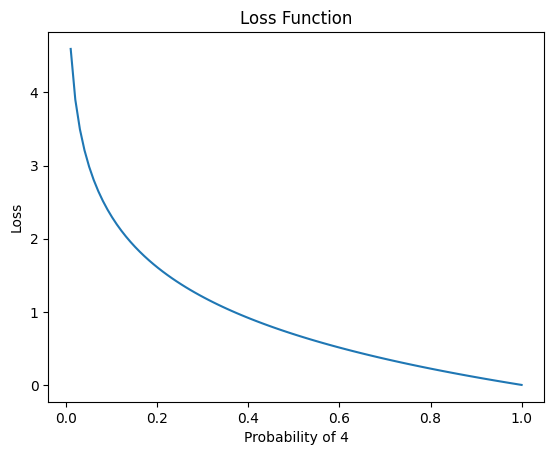

In [25]:
# plot out - log(x) where x ranges from 0 to 1
# The x should be labled as probability and y should be labeled as loss
import matplotlib.pyplot as plt
import numpy as np



x = np.linspace(0, 1, 100)
y = -np.log(x)

plt.plot(x, y)
plt.xlabel('Probability of 4')
plt.ylabel('Loss')
plt.title('Loss Function')

This function punishes bad predictions with infinite loss, and good predictions get 0 loss. You've probably cheated by looking at the cell and realized this magic function is $-log(p)$

### Cross-Entropy Formula 

We can use a clever formula to penalize the difference between $y$ and the predicted probabilities $\hat{y}$. It is defined as:

$$
H(p, q) = -\sum_{i=1}^C y_i \log(\hat{y}_i)
$$x


Where:
- $C$ is the number of classes.
- $y_i$ is the true label for class $i$ (1 if the true class is $i$, otherwise 0 in one-hot encoding).
- $\hat{y}_i$ is the predicted probability for class $i$.
- The summation iterates over all classes.

This formula penalizes predictions that deviate from the true class's probability distribution. If the predicted probability for the true class is close to 1, the loss is minimal.


## Cross Entropy on a Uniform Distribution

The average cross-entropy for a uniform distribution with $C = 10$ classes is derived as follows:

$$
H(p, q) = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

For a uniform distribution, each predicted probability is $\hat{y}_i = \frac{1}{C}$ and only the true class contributes to the sum ($y_i = 1$ for the true class, $0$ otherwise):

$$
H(p, q) = -\log\left(\frac{1}{C}\right)
$$

Substituting $C = 10$:

$$
H(p, q) = -\log\left(\frac{1}{10}\right) \approx 2.3
$$


it's 2.3, just as we expected!!

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax')
])

/home/jackson/code/dl/venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
scce = tf.keras.losses.SparseCategoricalCrossentropy()

pred_train = model(x_train)

loss = scce(y_train, pred_train)

print(loss)

tf.Tensor(179.74203, shape=(), dtype=float32)


I'm a little surprised the sparse entropy loss is so high. I would expect it to be around 2.3 like the uniform model.

Let's calculate this ourselves to see what's going on.


In [58]:
# cross_entropy = -tf.reduce_sum(tf.one_hot(y_train, depth=10) * tf.math.log(pred_train + 1e-30), axis=1)  # Avoid log(0) with small epsilon

 
tf.math.log(pred_train) * tf.one_hot(y_train, depth=10)

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[      nan,       nan,       nan, ...,  -0.     ,       nan,
              nan],
       [     -inf,       nan,  -0.     , ...,  -0.     ,  -0.     ,
          0.     ],
       [ -0.     ,       nan,  -0.     , ...,       nan,       nan,
         -0.     ],
       ...,
       [      nan,       nan,  -0.     , ...,  -0.     ,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [ -0.     ,       nan,  -0.     , ...,  -0.     , -58.72172,
         -0.     ]], dtype=float32)>

In [66]:
from math import log, log10

-log(1/10)

2.3025850929940455

In [16]:
with tf.GradientTape() as tape:
    pred_train = model(x_train)

    loss = scce(y_train, pred_train)

gradients = tape.gradient(loss, model.trainable_variables)


Reshaped gradient shape: (28, 28, 10)


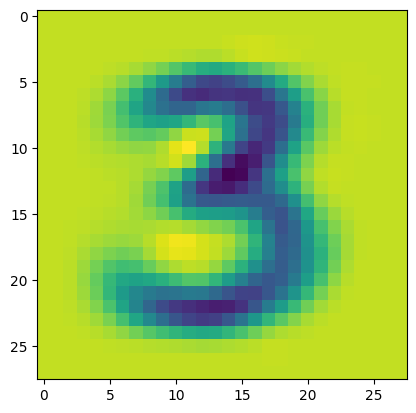

In [42]:
# let's look at gradients



from matplotlib import pyplot as plt

reshaped_gradient = tf.reshape(gradients[0], (28, 28, 10))
print("Reshaped gradient shape:", reshaped_gradient.shape)

plt.imshow(reshaped_gradient[:,:, 3])